<a href="https://www.kaggle.com/code/skrmanglam/chatbot-sentiment-analysis?scriptVersionId=162523296" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TextDataset, Trainer, TrainingArguments
from torch.utils.data import Dataset

class EngineerResponseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and define max_length
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
max_length = 128

# Prepare data
engineer_responses = [
    "Hi Roberto, We have de-staged the stores with poslast and provided menu maker access. Store UUID : 7dad6eeb-4746 A46d97...",
    # Add more engineer responses
]
empathy_labels = [0, 0, 0, 0, 1]  # Fail: 0, Pass: 1

# Create custom dataset
dataset = EngineerResponseDataset(engineer_responses, empathy_labels, tokenizer, max_length)

# Load pre-trained GPT model for sequence classification
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)


2024-02-11 16:32:32.120996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 16:32:32.121122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 16:32:32.257313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch

# Initialize GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Add padding token
tokenizer.pad_token = tokenizer.eos_token

# Example engineer response to test
test_text = "Hi Roberto,\nWe have de-staged the stores with poslast and provided menu maker access.\nStore UUID :\n7dad6eeb-4746\nA46d97e2-e99\nA26f3b8a-4ffc 02\nEfb224ca-04\nIf you feel your request was not addressed/resolved properly, you can reopen the same case\nwithin 3 business working days and/or request escalation. If you have a new issue, please raise\na new case.\nRegards,\nL2 UET Support"

# Tokenize the test text
encoding = tokenizer(test_text, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Perform inference
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)  # Load the pre-trained model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(**encoding)

# Get predicted label
logits = outputs.logits
predicted_label = torch.argmax(logits, dim=1).item()

# Convert label to its corresponding string representation
predicted_label_str = "Fail" if predicted_label == 0 else "Pass"

print("Predicted Empathy Label:", predicted_label_str)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Empathy Label: Pass


As we can see that with either zero shot learning or with minimal amount of data it is not possible to train the network for sufficient accuracy.

## Multilabel Classification

Lets approach the problem the usal way and solve this problem using GoEmotions dataset. About the dataset: GoEmotions [Demszky et al., ACL 2020] (https://arxiv.org/pdf/2005.00547.pdf) is a human-annotated dataset of 58k (train: 43410, val: 5426, test: 5427) Reddit comments extracted from popular English-language subreddits and labeled with 27 emotion categories. The dataset includes 12 positive, 11 negative, 4 ambiguous emotion categories and 1 “neutral”. Not limited to the basic six emotions (fear, anger, joy, sadness, disgust, and surprise) makes it widely suitable for conversation understanding tasks that require a subtle differentiation between emotion expressions.

|&emsp;&emsp; Comment &emsp;&emsp;&emsp;&emsp; | &emsp;&emsp;&emsp;&emsp; Emotion Category &emsp; |
|-|:-|
|1.&emsp;&emsp; OMG, yep!!!That is the final answer! Thank you so much!|&emsp;&emsp;&emsp;&emsp;&emsp;🤩&emsp;👍&emsp;🙏|
|2.&emsp;&emsp; I am so glad this is over.|&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 😌|
|3.&emsp;&emsp; Sorry, I feel bad for having said that.|&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 😔|

* `Comment 1` expresses several emotions at once, including excitement, approval and gratitude.
* `Comment 2` expresses relief, a complex emotion conveying both positive and negative sentiment.
* `Comment 3` conveys remorse, a complex emotion that is expressed frequently but is not captured by simple models of emotion.


Note: Since our problem scope only asks us to do empathy vrs other, we will later map this multiple emotions into empathy and non-empathy based on similarity.

# Import dependencies

In [4]:
!pip install transformers >> NULL

In [5]:
import nltk
import numpy as np
import pandas as pd
import gensim
import transformers
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset Loading

In [6]:
# Load Goemotion dataset
!pip install datasets >> NULL
from datasets import load_dataset
dataset = load_dataset("go_emotions", "simplified")
#dataset = dataset.data
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
df_train.head()

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


# Check the size of each set (train, test)
print("Size of train set: ", df_train.shape[0])
print("Size of train set: ", df_test.shape[0])

In [8]:
emotion_list = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
print(len(emotion_list))

28


In [9]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [10]:
df_train['Emotions'] = df_train['labels'].apply(idx2class)
df_test['Emotions'] = df_test['labels'].apply(idx2class)

In [11]:
df_train.head()

,text,labels,id,Emotions
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral]
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger]
3,To make her feel threatened,[14],ed7ypvh,[fear]
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance]


# Emotion Mapping

Now mapping the emotions to Empathy or Non_Empathy based on similarity.

In [12]:
empathy_mapping = {
"non_empathy": ["anger","annoyance","disapproval","disgust","fear","nervousness","joy","amusement","excitement","pride","admiration","desire","sadness", "disappointment", "embarrassment", "grief",  "remorse", "surprise","confusion", "curiosity"],
"empathy": ["approval",  "gratitude","love", "optimism", "relief","caring", "realization"]
}

In [13]:
def EmotionMapping(emotion_list):
    map_list = []
    for i in emotion_list:
        if i in empathy_mapping['non_empathy']:
            map_list.append('non_empathy')
        if i in empathy_mapping['empathy']:
            map_list.append('empathy')
        if i == 'neutral':
            map_list.append('non_empathy')   
    return map_list

In [14]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_test['Mapped Emotions'] = df_test['Emotions'].apply(EmotionMapping)

In [15]:
df_train.head()

,text,labels,id,Emotions,Mapped Emotions
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],[non_empathy]
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],[non_empathy]
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],[non_empathy]
3,To make her feel threatened,[14],ed7ypvh,[fear],[non_empathy]
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],[non_empathy]


### One Hot encoding the label column

In [16]:
# label encoded vectors
for i in ['empathy', 'non_empathy']:
  df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
  df_test[i] = df_test['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)


In [17]:
#data frame with one hot encoded columns for empathy and non-empathy
df_train.head()

,text,labels,id,Emotions,Mapped Emotions,empathy,non_empathy
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],[non_empathy],0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],[non_empathy],0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],[non_empathy],0,1
3,To make her feel threatened,[14],ed7ypvh,[fear],[non_empathy],0,1
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],[non_empathy],0,1


In [18]:
# dropping irrelevant columns to avoid noise in the data
df_train.drop(['labels', 'id', 'Emotions', 'Mapped Emotions'], axis=1, inplace=True)
df_test.drop(['labels', 'id', 'Emotions', 'Mapped Emotions'], axis=1, inplace=True)

In [19]:
df_train.head()

,text,empathy,non_empathy
0,My favourite food is anything I didn't have to...,0,1
1,"Now if he does off himself, everyone will thin...",0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,1
3,To make her feel threatened,0,1
4,Dirty Southern Wankers,0,1


# EDA and understanding the distribution of the data

In [20]:
categories = list(df_train.columns.values)
categories = categories[1:]
print(categories)

['empathy', 'non_empathy']


In [21]:
counts = []
for category in categories:
    counts.append((category, df_train[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'no_of_comments'])
df_stats

,category,no_of_comments
0,empathy,10820
1,non_empathy,35422


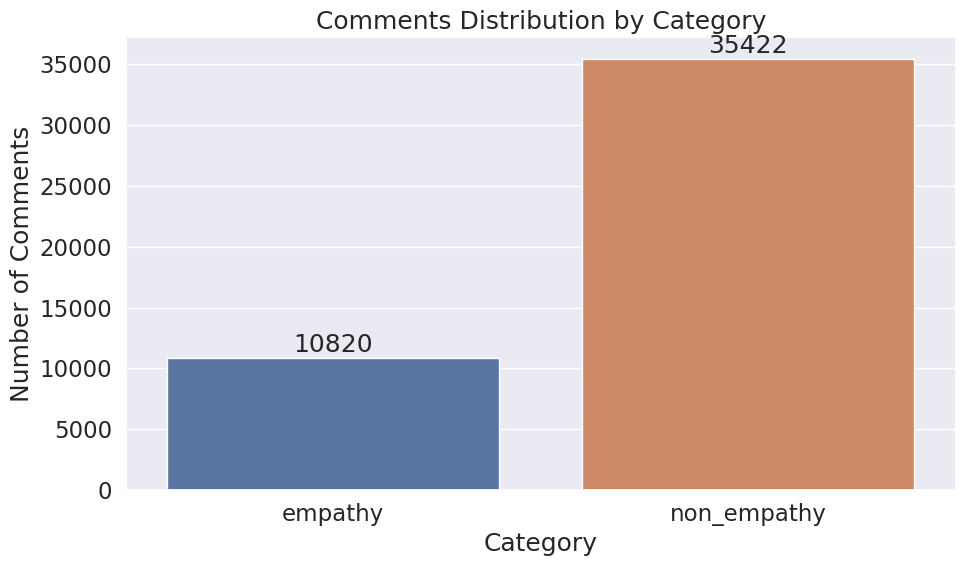

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set font scale
sns.set(font_scale=1.5)

# Create bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='category', y='no_of_comments', data=df_stats)

# Add labels to the bars
for rect, label in zip(ax.patches, df_stats['no_of_comments']):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 100, label,
            ha='center', va='bottom')

# Set plot title and labels
plt.title("Comments Distribution by Category")
plt.ylabel('Number of Comments')
plt.xlabel('Category')

# Enable tight layout
plt.tight_layout()

plt.show()


WordCloud representation is useful to find most used words in each emotion. This might help us in debugging later if we have clubbed the emotions incorrectly

In [23]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

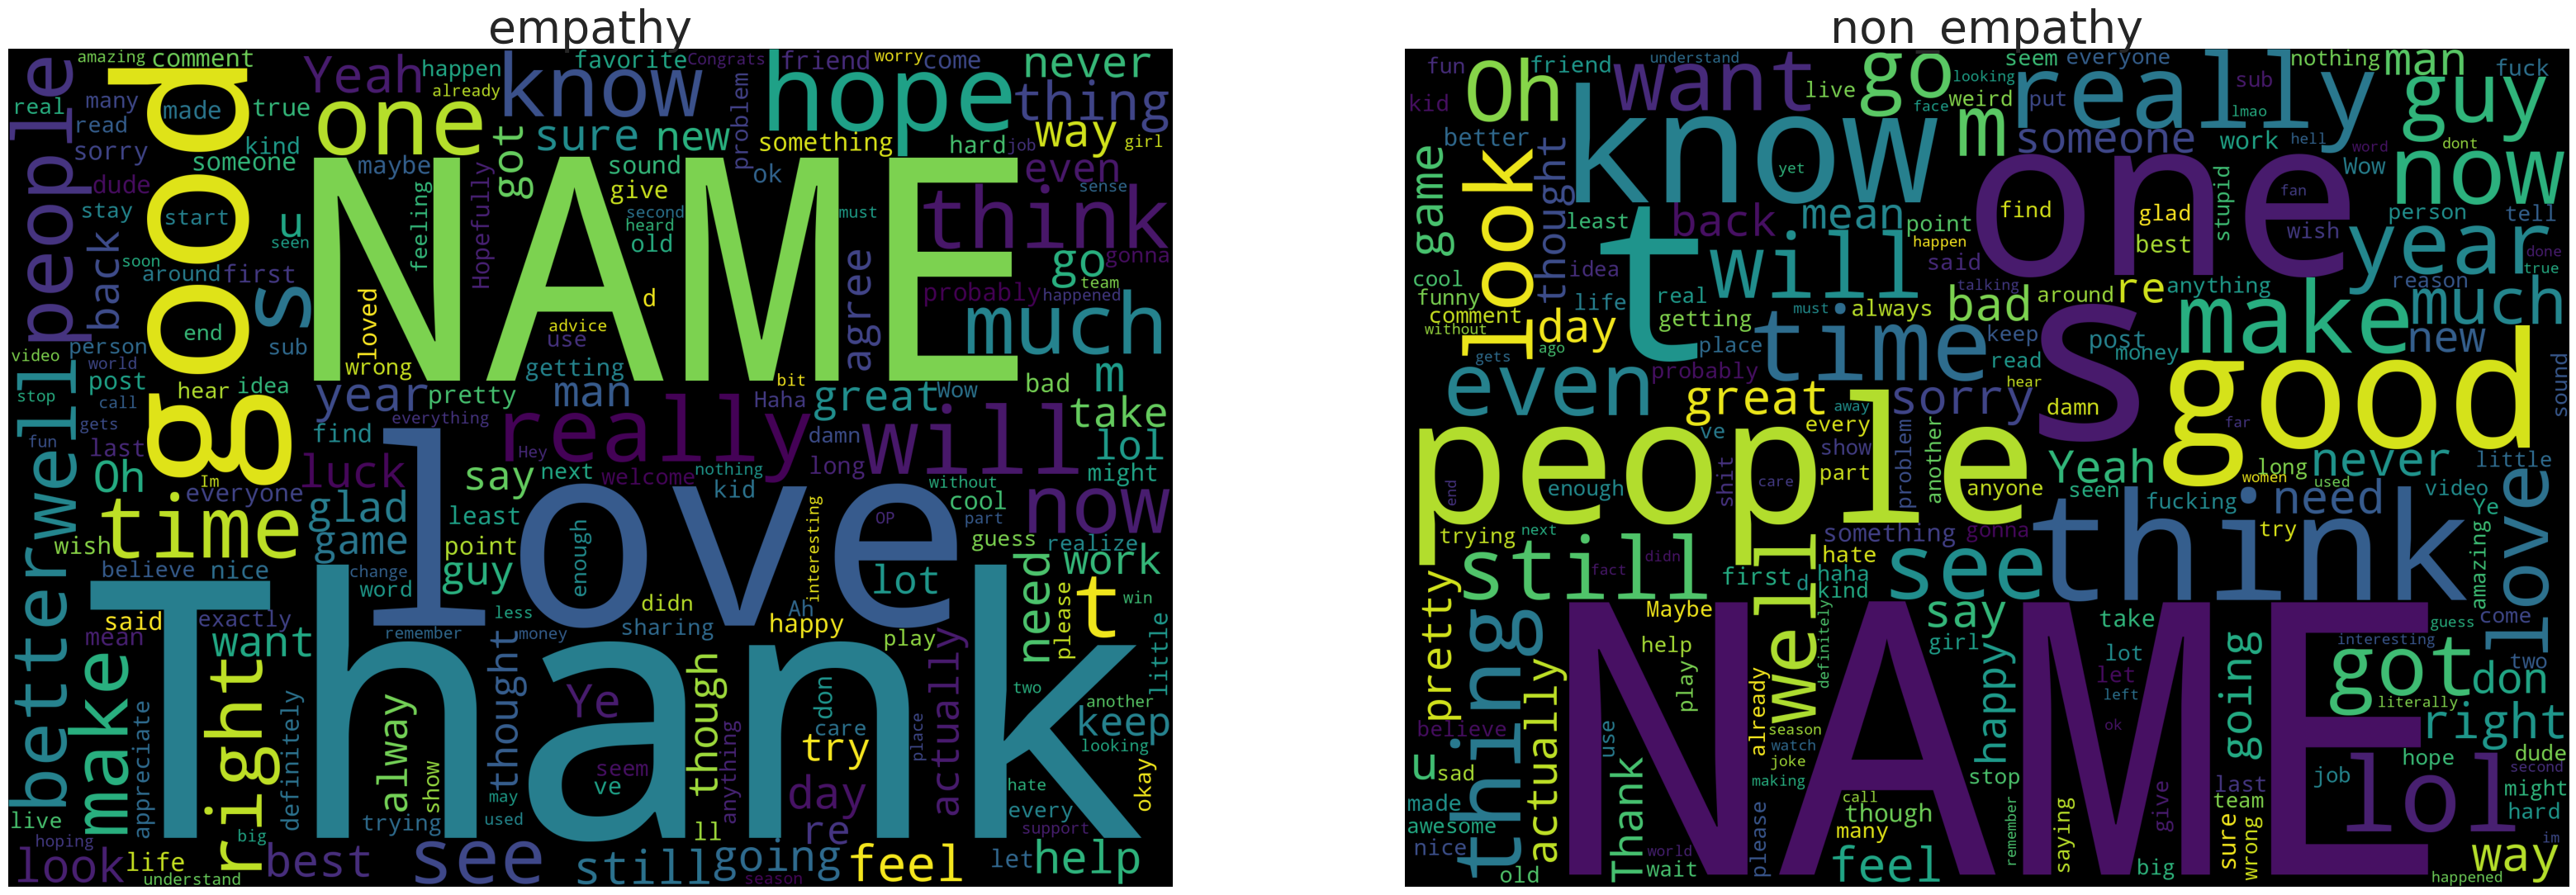

In [24]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# empathy
subset = df_train[df_train.empathy==1]
text = subset.text.values
cloud_joy = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("empathy",fontsize=40)
plt.imshow(cloud_joy)


# non_empathy
subset = df_train[df_train.non_empathy ==1]
text = subset.text.values
cloud_sadness = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("non_empathy",fontsize=40)
plt.imshow(cloud_sadness)

plt.show()

# 3. Data Pre-processing

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 3.1. Cleaning Data

In [26]:
def remove_space(text):
    '''Removes awkward spaces'''
    text = text.strip()
    text = text.split()
    return " ".join(text)

def cleanPunc(text): 
    '''function to clean the word of any punctuation or special characters'''
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(text):
    alpha_sent = ""
    for word in text.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = remove_space(text)
    text = cleanPunc(text)
    text = keepAlpha(text)
    return text

In [27]:
df_train['clean_text'] = df_train['text'].str.lower()
df_train['clean_text'] = df_train['text'].apply(text_preprocessing_pipeline)
df_test['clean_text'] = df_test['text'].apply(text_preprocessing_pipeline)
df_train.head()

,text,empathy,non_empathy,clean_text
0,My favourite food is anything I didn't have to...,0,1,My favourite food is anything I didnt have to ...
1,"Now if he does off himself, everyone will thin...",0,1,Now if he does off himself everyone will think...
2,WHY THE FUCK IS BAYLESS ISOING,0,1,WHY THE FUCK IS BAYLESS ISOING
3,To make her feel threatened,0,1,To make her feel threatened
4,Dirty Southern Wankers,0,1,Dirty Southern Wankers


# 3.2. Stemming

In [28]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
  # Exersice 2
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

df_train['clean_text'] = df_train['clean_text'].apply(stemming)
df_train.head()

,text,empathy,non_empathy,clean_text
0,My favourite food is anything I didn't have to...,0,1,my favourit food is anyth i didnt have to cook...
1,"Now if he does off himself, everyone will thin...",0,1,now if he doe off himself everyon will think h...
2,WHY THE FUCK IS BAYLESS ISOING,0,1,whi the fuck is bayless iso
3,To make her feel threatened,0,1,to make her feel threaten
4,Dirty Southern Wankers,0,1,dirti southern wanker


# Empathy Analysis with LLM

In [29]:
# # combibing empathy and non-empathy cols
# df_train['labels'] = df_train['empathy'].apply(lambda x:1 if x == 1 else 0)
#df_train.drop(['empathy', 'non_empathy'], axis =1, inplace = True)

# Select 'clean_text' as features (X) and 'labels' as labels (y)
X_train = df_train['clean_text']
y_train = df_train['empathy']
df_train

,text,empathy,non_empathy,clean_text
0,My favourite food is anything I didn't have to...,0,1,my favourit food is anyth i didnt have to cook...
1,"Now if he does off himself, everyone will thin...",0,1,now if he doe off himself everyon will think h...
2,WHY THE FUCK IS BAYLESS ISOING,0,1,whi the fuck is bayless iso
3,To make her feel threatened,0,1,to make her feel threaten
4,Dirty Southern Wankers,0,1,dirti southern wanker
...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,1,0,ad you mate well i ve just got the bow and i l...
43406,Always thought that was funny but is it a refe...,0,1,alway thought that was funni but is it a refer...
43407,What are you talking about? Anything bad that ...,0,1,what are you talk about anyth bad that happen ...
43408,"More like a baptism, with sexy results!",0,1,more like a baptism with sexi result


In [30]:
X_test = df_test['clean_text']
y_test = df_test['empathy']
df_test

,text,empathy,non_empathy,clean_text
0,I’m really sorry about your situation :( Altho...,0,1,I m really sorry about your situation Althou...
1,It's wonderful because it's awful. At not with.,0,1,Its wonderful because its awful At not with
2,"Kings fan here, good luck to you guys! Will be...",0,1,Kings fan here good luck to you guys Will be a...
3,"I didn't know that, thank you for teaching me ...",1,0,I didnt know that thank you for teaching me so...
4,They got bored from haunting earth for thousan...,0,1,They got bored from haunting earth for thousan...
...,...,...,...,...
5422,Thanks. I was diagnosed with BP 1 after the ho...,1,0,Thanks I was diagnosed with BP after the hos...
5423,Well that makes sense.,1,0,Well that makes sense
5424,Daddy issues [NAME],0,1,Daddy issues NAME
5425,So glad I discovered that subreddit a couple m...,0,1,So glad I discovered that subreddit a couple m...


In [31]:
print('length of x_train', len(X_train))
print('length of y_train', len(y_train))
print('length of x_test', len(X_test))
print('length of y_test', len(y_test))

length of x_train 43410
length of y_train 43410
length of x_test 5427
length of y_test 5427


In [32]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from transformers import BertTokenizer
import tensorflow as tf

# Load your data from Pandas DataFrame
# Assuming you have 'train_df' and 'test_df' DataFrames
train_texts = X_train.tolist()
train_labels = y_train.tolist()

test_texts = X_test.tolist()
test_labels = y_test.tolist()

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and preprocess the training and test data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create TensorFlow datasets from tokenized data
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)

# Determine the size of the validation set (e.g., 20% of the total dataset)
val_size = int(0.2 * len(train_dataset))

# Take the first val_size batches from the shuffled train_dataset as the validation dataset
val_dataset = train_dataset.take(val_size)

# Take the remaining batches as the training dataset
train_dataset = train_dataset.skip(val_size)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [34]:
# Define your optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Define the EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor the validation accuracy
    patience=3,               # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
model.fit(
    train_dataset,
    epochs=20,
    steps_per_epoch=115,
    callbacks=[early_stopping_callback],  # Pass the EarlyStopping callback
    validation_data=val_dataset  # Assuming you have validation data
)

Epoch 1/20


I0000 00:00:1707669360.853485      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 [==============================] - 158s 935ms/step - loss: 0.4491 - accuracy: 0.8204 - val_loss: 0.3879 - val_accuracy: 0.8451
Epoch 2/20
115/115 [==============================] - 103s 897ms/step - loss: 0.3920 - accuracy: 0.8505 - val_loss: 0.3758 - val_accuracy: 0.8486
Epoch 3/20
115/115 [==============================] - 103s 898ms/step - loss: 0.3710 - accuracy: 0.8573 - val_loss: 0.3664 - val_accuracy: 0.8517
Epoch 4/20
115/115 [==============================] - 102s 896ms/step - loss: 0.3851 - accuracy: 0.8451 - val_loss: 0.4130 - val_accuracy: 0.8260
Epoch 5/20
115/115 [==============================] - 103s 896ms/step - loss: 0.3836 - accuracy: 0.8443 - val_loss: 0.3581 - val_accuracy: 0.8578
Epoch 6/20
115/115 [==============================] - 102s 894ms/step - loss: 0.3485 - accuracy: 0.8595 - val_loss: 0.3512 - val_accuracy: 0.8562
Epoch 7/20
115/115 [==============================] - 102s 895ms/step - loss: 0.3629 - accuracy: 0.8522 - val_loss: 0.3650 - val_accura

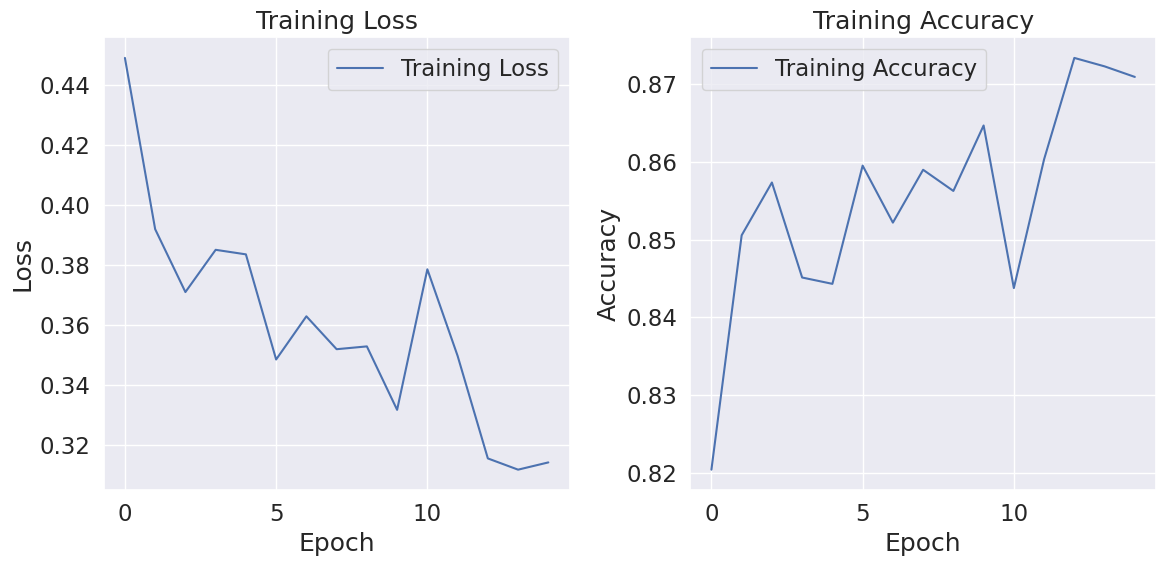

In [35]:
import matplotlib.pyplot as plt

# Access training history
history = model.history.history

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
#Tokenize and preprocess the training and test data
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=128)

# Convert the tokenized test data into TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"],
        # Ensure compatibility with models that don't use `token_type_ids`
        "token_type_ids": test_encodings.get("token_type_ids", tf.zeros_like(test_encodings["input_ids"]))
    },
    test_labels
)).batch(32)  # Batch the test dataset

# Evaluate the model on the test dataset
evaluation = model.evaluate(test_dataset)




170/170 [==============================] - 31s 165ms/step - loss: 0.3583 - accuracy: 0.8620


In [37]:
# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Test Loss: 0.3582628667354584
Test Accuracy: 0.8619863390922546


In [38]:
engineer_responses = [
    "Hi Roberto,\nWe have de-staged the stores with poslast and provided menu maker access.\nStore UUID :\n7dad6eeb-4746\nA46d97e2-e99\nA26f3b8a-4ffc 02\nEfb224ca-04\nIf you feel your request was not addressed/resolved properly, you can reopen the same case\nwithin 3 business working days and/or request escalation. If you have a new issue, please raise\na new case.\nRegards,\nL2 UET Support",
    "Hi fan,Please follow the below documents to update the modifiers in the menu payload.https://develohttps:/develoStore UUID: 7140faaIf you feel the issue is not addressed/resolved properly you can reopen the same case within 3business working days or If you have a new issue please raise a new case.Thanks,L2 UET Support",
    "Hi kaj,Please try understanding the situation. All the menu changes need to be done from POS sidewhen the store was POS integrated. We understand that the uber has 2 pricing options but thatalso needs to be updated from POS side.If you want to update the prices, then we can provide menu edit access but after a menu synchappens from POS then the menu will be overridden. So, We request you to please reach out toSquare POS and let them assist with the situation.Store UUID - f264If you feel the issue is not addressed/resolved properly you can reopen the same case within 3business working days or If you have a new issue please raise a new case.Thanks,L2 UET Support",
    "Hi There,We have checked the below store, the store is well staged with clover pos.The store uuid:- 19c9pos provider :-InfoClient ID: h5_UUhrR57LkVApp Owner UUID: c84bb38We have done the menu refresh was store, and the menu refresh was successful. we could see thestill item was out of stock. please try to update the menu from Clover dashboard. please reach out topos provider for help.If you feel the issue has not been addressed or resolved properly, you can reopen the same casewithin 3 business days. If you have a new issue, please raise a new case.Thanks,L2 UET support"
]

# Corresponding true labels for the inputs
true_labels = ["non_empathy", "non_empathy", "non_empathy", "empathy"]

# Tokenize the engineer responses and convert them to token IDs
encoded_inputs = tokenizer(engineer_responses, truncation=True, padding= True, max_length=128, return_tensors = "tf")

input_dict = {key: encoded_inputs[key] for key in encoded_inputs}

# Make predictions using the model
predictions = model.predict(input_dict)


classes = ['empathy', 'non_empathy']
# Process the predictions as needed
# For example, if you're doing classification and want to get class labels:
predicted_labels = [classes[np.argmax(pred)] for pred in  predictions['logits']]

# Output the predicted labels
print("Predicted labels:", predicted_labels)

# Compare predicted labels to true labels
accuracy = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred) / len(true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

1/1 [==============================] - 3s 3s/step
Predicted labels: ['empathy', 'non_empathy', 'non_empathy', 'non_empathy']
Accuracy: 50.00%
